# ME 5920 FINAL PROJECT - SCIENTIFIC SIMULATIONS GROUP 1



## Group Members



1.   George Ayobami Thomas
2.   Mridul Bhattarai
3.   Hossein Asgaribakhtiari



## 1.1. Setup and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

Mounted at /content/drive


## 1.2. Load data from Google Drive (dataset 1)


In [ ]:
DATA_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TRAIN_FD002.xlsx'
df = pd.read_excel(DATA_PATH)

# Inspect
print(df.head())

   Engine_ID  Cy_F     OP_1    OP_2  OP_3     S_1     S_2      S_3      S_4  \
0          1     1  34.9983  0.8400   100  449.44  555.32  1358.61  1137.23   
1          1     2  41.9982  0.8408   100  445.00  549.90  1353.22  1125.78   
2          1     3  24.9988  0.6218    60  462.54  537.31  1256.76  1047.45   
3          1     4  42.0077  0.8416   100  445.00  549.51  1354.03  1126.38   
4          1     5  25.0005  0.6203    60  462.54  537.07  1257.71  1047.93   

    S_5  ...     S_14     S_15  S_16  S_17  S_18    S_19   S_20    S_21  \
0  5.48  ...  8048.56   9.3461  0.02   334  2223  100.00  14.73  8.8071   
1  3.91  ...  8072.30   9.3774  0.02   330  2212  100.00  10.41  6.2665   
2  7.05  ...  7864.87  10.8941  0.02   309  1915   84.93  14.08  8.6723   
3  3.91  ...  8068.66   9.3528  0.02   329  2212  100.00  10.59  6.4701   
4  7.05  ...  7861.23  10.8963  0.02   309  1915   84.93  14.13  8.5286   

   Unnamed: 26  RUL  
0          NaN  148  
1          NaN  147  
2       

## 1.3. Preprocessing and dataset definition


In [ ]:
FEATURE_COLS = ['OP_1', 'OP_2', 'OP_3'] + [f'S_{i}' for i in range(1, 22)]
TARGET_COL = 'RUL'
ID_COL = 'Engine_ID'
CYCLE_COL = 'Cy_F'

print(df[ID_COL].shape)

# Split engines into train/val
engine_ids = df[ID_COL].unique()
train_ids, val_ids = train_test_split(engine_ids, test_size=0.1, random_state=25)

(53759,)


## 1.4. Feature selection using correlation

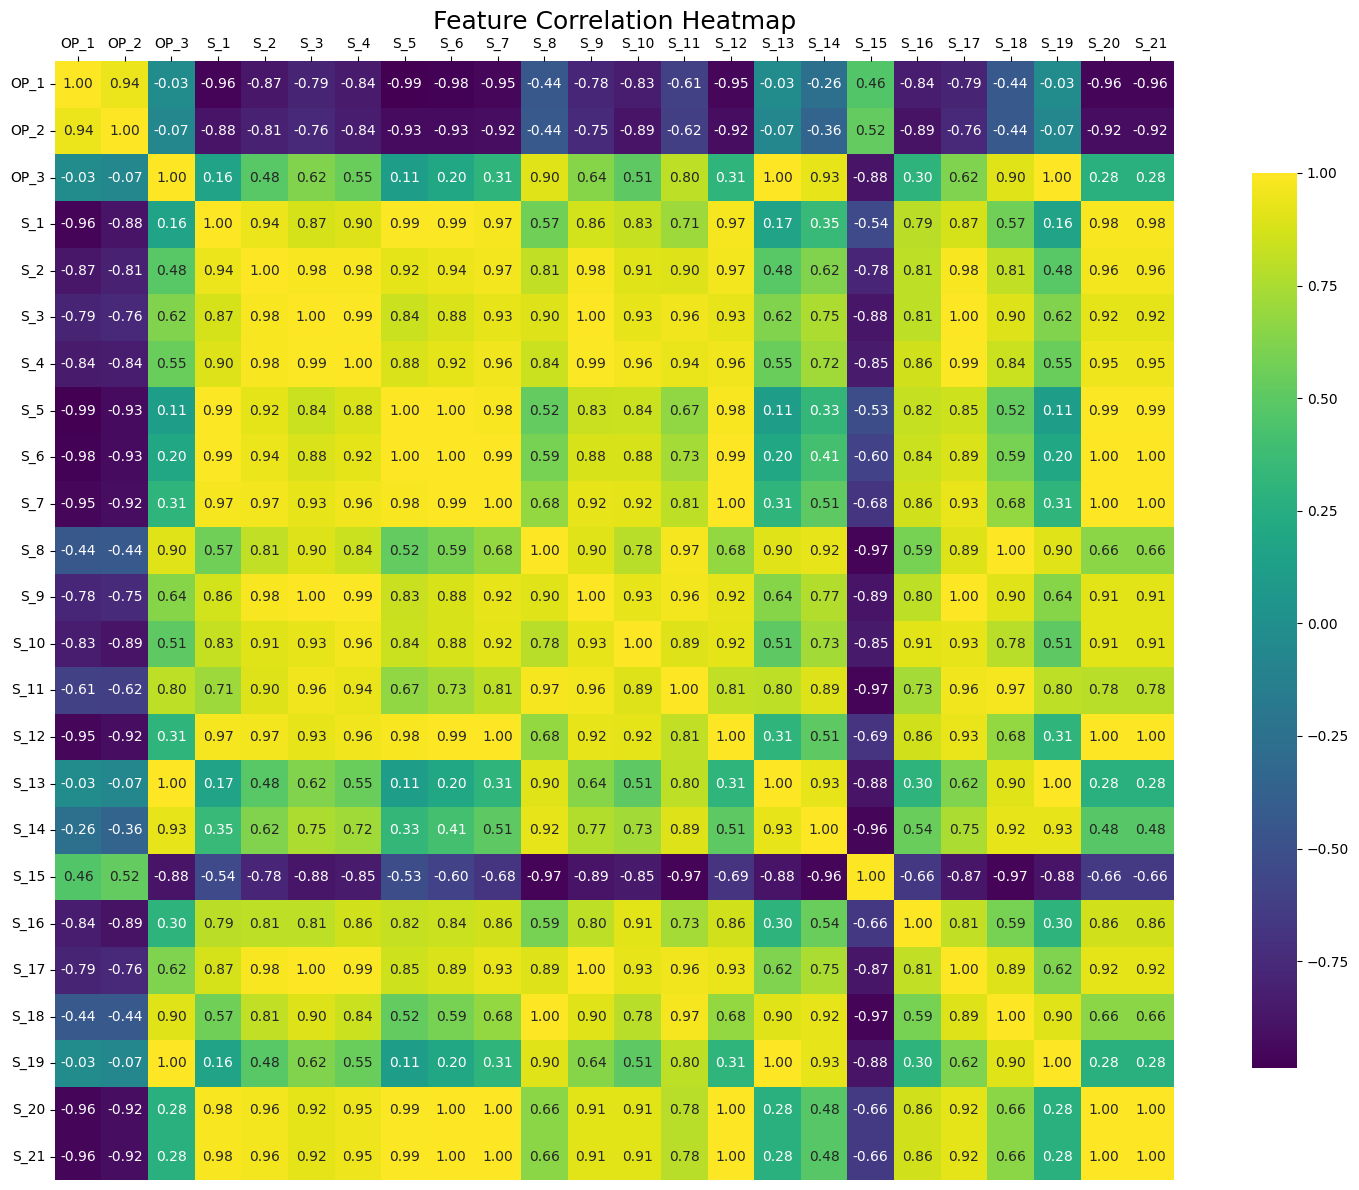

Removing 'S_1' due to high correlation (-0.964) with 'OP_1'
Removing 'S_3' due to high correlation (0.982) with 'S_2'
Removing 'S_4' due to high correlation (0.981) with 'S_2'
Removing 'S_5' due to high correlation (-0.987) with 'OP_1'
Removing 'S_6' due to high correlation (-0.976) with 'OP_1'
Removing 'S_7' due to high correlation (-0.952) with 'OP_1'
Removing 'S_9' due to high correlation (0.979) with 'S_2'
Removing 'S_10' due to high correlation (0.962) with 'S_4'
Removing 'S_11' due to high correlation (0.961) with 'S_3'
Removing 'S_12' due to high correlation (-0.951) with 'OP_1'
Removing 'S_13' due to high correlation (1.000) with 'OP_3'
Removing 'S_15' due to high correlation (-0.971) with 'S_8'
Removing 'S_17' due to high correlation (0.983) with 'S_2'
Removing 'S_18' due to high correlation (1.000) with 'S_8'
Removing 'S_19' due to high correlation (1.000) with 'OP_3'
Removing 'S_20' due to high correlation (-0.962) with 'OP_1'
Removing 'S_21' due to high correlation (-0.962)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

X_train = df.loc[df[ID_COL].isin(train_ids), FEATURE_COLS]

# Compute correlation for alll the combination of two features
corr_matrix = X_train.corr()

# Plot
plt.figure(figsize=(16,12))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis", square=True, cbar_kws={"shrink": .8})

# Title and ticks formatting
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.xaxis.set_ticks_position('top')# Move x-axis ticks to the top
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.show()


# Set to hold columns to drop
col_corr = set()

threshold = 0.95

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]

            if colname_i not in col_corr:
                print(f"Removing '{colname_i}' due to high correlation ({corr_matrix.iloc[i, j]:.3f}) with '{colname_j}'")
                col_corr.add(colname_i)
# New feature
New_Feature_Cols = [col for col in FEATURE_COLS if col not in col_corr]
print ("New Feature cols:","\n=================\n",New_Feature_Cols)

## 1.5. Drop the columns in 'train_corr' before applying scaling

In [ ]:
df_raw = df.copy() #dataframe with all the features
df_corr = df.copy() #dataframe with reduced featres
df_corr = df_corr.drop(columns=col_corr)

#Normalize features per column
scaler_raw=StandardScaler()
scaler_corr=StandardScaler()

df_raw[FEATURE_COLS]=scaler_raw.fit_transform(df_raw.loc[:,FEATURE_COLS])
df_corr[New_Feature_Cols] = scaler_corr.fit_transform(df_corr.loc[:, New_Feature_Cols])

from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler = StandardScaler()
train_ruls = df.loc[df[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1,1)
rul_scaler.fit(train_ruls)

# New column 'RUL_s' for the scaled targets
df_raw['RUL_s'] = df_raw[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

df_corr['RUL_s'] = df_corr[TARGET_COL].astype(np.float64).values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls)

# Scale val targets (so loss is computed on same scale)
val_ruls_raw = df_raw.loc[df_raw[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_raw.loc[df_raw[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_raw)

val_ruls_corr = df_corr.loc[df_corr[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1,1)
df_corr.loc[df_corr[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_corr)
# Update target column name
TARGET_COL_S = 'RUL_s'


def make_sequences(Feature_Cols, df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[Feature_Cols].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

WINDOW_SIZE = 1

train_seqs_raw = make_sequences(FEATURE_COLS, df_raw, train_ids, WINDOW_SIZE)
val_seqs_raw   = make_sequences(FEATURE_COLS, df_raw, val_ids, WINDOW_SIZE)

train_seqs_corr = make_sequences(New_Feature_Cols, df_corr, train_ids, WINDOW_SIZE)
val_seqs_corr  = make_sequences(New_Feature_Cols, df_corr, val_ids, WINDOW_SIZE)

class SequenceDataset(Dataset):
    def __init__(self, seqs):
        self.seqs = seqs
    def __len__(self):
        return len(self.seqs)
    def __getitem__(self, idx):
        x, y = self.seqs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

train_ds_raw = SequenceDataset(train_seqs_raw)
val_ds_raw   = SequenceDataset(val_seqs_raw)

train_loader_raw = DataLoader(train_ds_raw, batch_size=64, shuffle=False)
val_loader_raw   = DataLoader(val_ds_raw, batch_size=64)


train_ds_corr = SequenceDataset(train_seqs_corr)
val_ds_corr  = SequenceDataset(val_seqs_corr)

train_loader_corr = DataLoader(train_ds_corr, batch_size=64, shuffle=False)
val_loader_corr   = DataLoader(val_ds_corr, batch_size=64)

## 2.1. Long Short-Term Memory (LSTM) model definition

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last   = out[:, -1, :]
        return self.fc(last).squeeze()

## 2.2. Transformer model definition

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_enc  = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out      = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        last = x[:, -1, :]
        return self.fc_out(last).squeeze()


## 2.3. Fully Connected Neural Network (FCNN) definition

In [ ]:
class FCRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

## 2.3.1. Flattened dataset for FCNN

In [ ]:
class FlattenedDataset(Dataset):
    def __init__(self, seqs):
        self.x = [torch.tensor(s[0].flatten(), dtype=torch.float32) for s in seqs]
        self.y = [torch.tensor(s[1], dtype=torch.float32) for s in seqs]

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

flat_train_ds_raw = FlattenedDataset(train_seqs_raw)
flat_val_ds_raw   = FlattenedDataset(val_seqs_raw)

flat_train_loader_raw = DataLoader(flat_train_ds_raw, batch_size=64)
flat_val_loader_raw   = DataLoader(flat_val_ds_raw, batch_size=64)

flat_train_ds_corr = FlattenedDataset(train_seqs_corr)
flat_val_ds_corr   = FlattenedDataset(val_seqs_corr)

flat_train_loader_corr = DataLoader(flat_train_ds_corr, batch_size=64)
flat_val_loader_corr   = DataLoader(flat_val_ds_corr, batch_size=64)

## 2.4. Convolutional Neural Network (CNN) regression model

In [ ]:
class CNNRegressor(nn.Module):
    def __init__(self, num_features, window_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        # x: [batch, window_size, features]
        x = x.permute(0, 2, 1)  # → [batch, features, window]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # → [batch, 64]
        return self.fc(x).squeeze(-1)  # → [batch]

## 3. Training and evaluation functions

In [ ]:
def train_epoch(model, loader, optim, criterion, device):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optim.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

## 4.1. Running LSTM


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm   = LSTMRegressor(input_dim=len(FEATURE_COLS), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm, train_loader_raw, opt_lstm, crit, device)
    val_loss   = eval_model(lstm, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.7591, Val MSE=0.9489
Epoch 2: LSTM Train MSE=0.5081, Val MSE=0.7670
Epoch 3: LSTM Train MSE=0.4700, Val MSE=0.7298
Epoch 4: LSTM Train MSE=0.4595, Val MSE=0.7103
Epoch 5: LSTM Train MSE=0.4541, Val MSE=0.6978
Epoch 6: LSTM Train MSE=0.4506, Val MSE=0.6892
Epoch 7: LSTM Train MSE=0.4479, Val MSE=0.6831
Epoch 8: LSTM Train MSE=0.4454, Val MSE=0.6786
Epoch 9: LSTM Train MSE=0.4432, Val MSE=0.6759
Epoch 10: LSTM Train MSE=0.4412, Val MSE=0.6755
Epoch 11: LSTM Train MSE=0.4395, Val MSE=0.6750
Epoch 12: LSTM Train MSE=0.4381, Val MSE=0.6719
Epoch 13: LSTM Train MSE=0.4369, Val MSE=0.6667
Epoch 14: LSTM Train MSE=0.4357, Val MSE=0.6612
Epoch 15: LSTM Train MSE=0.4346, Val MSE=0.6563
Epoch 16: LSTM Train MSE=0.4335, Val MSE=0.6524
Epoch 17: LSTM Train MSE=0.4325, Val MSE=0.6493
Epoch 18: LSTM Train MSE=0.4317, Val MSE=0.6468
Epoch 19: LSTM Train MSE=0.4309, Val MSE=0.6447
Epoch 20: LSTM Train MSE=0.4301, Val MSE=0.6431
Epoch 21: LSTM Train MSE=0.4294, Val MSE=0.6416
E

## 4.2. Running Transformer


In [ ]:
trans   = TransformerRegressor(input_dim=len(FEATURE_COLS), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans, train_loader_raw, opt_trans, crit, device)
    val_loss   = eval_model(trans, val_loader_raw, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=1.0417, Val MSE=1.2403
Epoch 2: Trans Train MSE=0.9226, Val MSE=1.1794
Epoch 3: Trans Train MSE=0.7856, Val MSE=1.1014
Epoch 4: Trans Train MSE=0.6814, Val MSE=1.0282
Epoch 5: Trans Train MSE=0.6516, Val MSE=0.9333
Epoch 6: Trans Train MSE=0.6265, Val MSE=0.9515
Epoch 7: Trans Train MSE=0.6022, Val MSE=0.9031
Epoch 8: Trans Train MSE=0.5662, Val MSE=0.7732
Epoch 9: Trans Train MSE=0.5253, Val MSE=0.7724
Epoch 10: Trans Train MSE=0.5071, Val MSE=0.7624
Epoch 11: Trans Train MSE=0.5013, Val MSE=0.7573
Epoch 12: Trans Train MSE=0.4963, Val MSE=0.7260
Epoch 13: Trans Train MSE=0.4885, Val MSE=0.7203
Epoch 14: Trans Train MSE=0.4876, Val MSE=0.7034
Epoch 15: Trans Train MSE=0.4859, Val MSE=0.7127
Epoch 16: Trans Train MSE=0.4816, Val MSE=0.6980
Epoch 17: Trans Train MSE=0.4765, Val MSE=0.6889
Epoch 18: Trans Train MSE=0.4736, Val MSE=0.7088
Epoch 19: Trans Train MSE=0.4696, Val MSE=0.6850
Epoch 20: Trans Train MSE=0.4623, Val MSE=0.7029
Epoch 21: Trans Train MSE=0.4

## 4.3. Running FCNN


In [ ]:
fcnn = FCRegressor(input_dim=len(FEATURE_COLS) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn, flat_train_loader_raw, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn, flat_val_loader_raw, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.8435, Val MSE=1.1178
Epoch 2: FCNN Train MSE=0.5421, Val MSE=0.8280
Epoch 3: FCNN Train MSE=0.4826, Val MSE=0.7446
Epoch 4: FCNN Train MSE=0.4635, Val MSE=0.7200
Epoch 5: FCNN Train MSE=0.4538, Val MSE=0.7076
Epoch 6: FCNN Train MSE=0.4492, Val MSE=0.7011
Epoch 7: FCNN Train MSE=0.4447, Val MSE=0.6973
Epoch 8: FCNN Train MSE=0.4417, Val MSE=0.6935
Epoch 9: FCNN Train MSE=0.4403, Val MSE=0.6788
Epoch 10: FCNN Train MSE=0.4360, Val MSE=0.6796
Epoch 11: FCNN Train MSE=0.4356, Val MSE=0.6698
Epoch 12: FCNN Train MSE=0.4345, Val MSE=0.6637
Epoch 13: FCNN Train MSE=0.4308, Val MSE=0.6738
Epoch 14: FCNN Train MSE=0.4304, Val MSE=0.6601
Epoch 15: FCNN Train MSE=0.4299, Val MSE=0.6523
Epoch 16: FCNN Train MSE=0.4285, Val MSE=0.6560
Epoch 17: FCNN Train MSE=0.4274, Val MSE=0.6465
Epoch 18: FCNN Train MSE=0.4282, Val MSE=0.6486
Epoch 19: FCNN Train MSE=0.4251, Val MSE=0.6395
Epoch 20: FCNN Train MSE=0.4241, Val MSE=0.6499
Epoch 21: FCNN Train MSE=0.4251, Val MSE=0.6416
E

## 4.4. Running CNN

In [ ]:
cnn_model = CNNRegressor(num_features=len(FEATURE_COLS), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3, weight_decay=1e-5)



for epoch in range(1, 101):
    cnn_model.train()
    total_loss = 0
    for xb, yb in train_loader_raw:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_raw.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_raw:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_raw.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.9130, Val Loss=1.1876
Epoch 2: CNN Train Loss=0.5896, Val Loss=0.9172
Epoch 3: CNN Train Loss=0.4861, Val Loss=0.7821
Epoch 4: CNN Train Loss=0.4650, Val Loss=0.7417
Epoch 5: CNN Train Loss=0.4554, Val Loss=0.7264
Epoch 6: CNN Train Loss=0.4497, Val Loss=0.7195
Epoch 7: CNN Train Loss=0.4460, Val Loss=0.7182
Epoch 8: CNN Train Loss=0.4423, Val Loss=0.7130
Epoch 9: CNN Train Loss=0.4406, Val Loss=0.7074
Epoch 10: CNN Train Loss=0.4382, Val Loss=0.6956
Epoch 11: CNN Train Loss=0.4366, Val Loss=0.6913
Epoch 12: CNN Train Loss=0.4366, Val Loss=0.6959
Epoch 13: CNN Train Loss=0.4334, Val Loss=0.6782
Epoch 14: CNN Train Loss=0.4322, Val Loss=0.6794
Epoch 15: CNN Train Loss=0.4339, Val Loss=0.6922
Epoch 16: CNN Train Loss=0.4339, Val Loss=0.6710
Epoch 17: CNN Train Loss=0.4302, Val Loss=0.6640
Epoch 18: CNN Train Loss=0.4285, Val Loss=0.6619
Epoch 19: CNN Train Loss=0.4272, Val Loss=0.6703
Epoch 20: CNN Train Loss=0.4271, Val Loss=0.6521
Epoch 21: CNN Train Loss=0.42

## 5. Compare final validation losses

In [ ]:
lstm_val  = eval_model(lstm, train_loader_raw, crit, device)
trans_val = eval_model(trans, train_loader_raw, crit, device)
fcnn_val  = eval_model(fcnn, flat_train_loader_raw, crit, device)
cnn_val   = eval_model(cnn_model, train_loader_raw, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3885, Transformer: 0.4207, FCNN: 0.3919, CNN: 0.3921


## 6. Load test data and run inference

In [ ]:
import matplotlib.pyplot as plt

TEST_PATH = '/content/drive/MyDrive/ME_5920/Final_Project/TEST_FD002.xlsx'
test_df   = pd.read_excel(TEST_PATH)

test_df_raw=test_df.copy()

# Remove columns that are in the col_corr set
test_df_corr=test_df.copy()
test_df_corr = test_df_corr.drop(columns=col_corr, errors='ignore')
test_df_corr.reset_index(drop=True, inplace=True)

# Apply same scaling
test_df_raw[FEATURE_COLS] = scaler_raw.transform(test_df_raw.loc[:, FEATURE_COLS])
test_df_raw[TARGET_COL_S] = rul_scaler.transform(test_df_raw[[TARGET_COL]])

test_df_corr[New_Feature_Cols] = scaler_corr.transform(test_df_corr.loc[:, New_Feature_Cols])
test_df_corr[TARGET_COL_S] = rul_scaler.transform(test_df_corr[[TARGET_COL]])

def make_test_sequences(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[FEATURE_COLS].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm(x_win).item())
                preds_t.append(trans(x_win).item())
                preds_f.append(fcnn(x_win).item())
                preds_c.append(cnn_model(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences(test_df_raw, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#7. Plot and save for a chosen engine

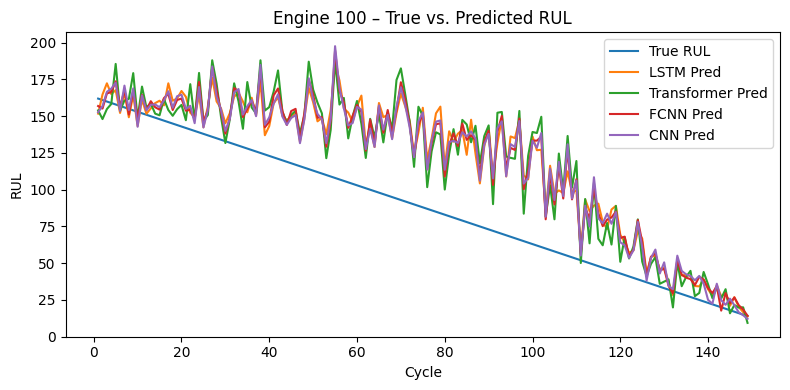

In [ ]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()

## 8.1. Running LSTM using new feature columns

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_corr   = LSTMRegressor(input_dim=len(New_Feature_Cols), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_corr.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_corr, train_loader_corr, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.9603, Val MSE=1.2954
Epoch 2: LSTM Train MSE=0.8972, Val MSE=1.2029
Epoch 3: LSTM Train MSE=0.8759, Val MSE=1.2670
Epoch 4: LSTM Train MSE=0.8555, Val MSE=1.2826
Epoch 5: LSTM Train MSE=0.8433, Val MSE=1.1593
Epoch 6: LSTM Train MSE=0.8386, Val MSE=1.1664
Epoch 7: LSTM Train MSE=0.8345, Val MSE=1.1689
Epoch 8: LSTM Train MSE=0.8317, Val MSE=1.1709
Epoch 9: LSTM Train MSE=0.8289, Val MSE=1.1789
Epoch 10: LSTM Train MSE=0.8262, Val MSE=1.1926
Epoch 11: LSTM Train MSE=0.8237, Val MSE=1.1978
Epoch 12: LSTM Train MSE=0.8217, Val MSE=1.1916
Epoch 13: LSTM Train MSE=0.8199, Val MSE=1.1859
Epoch 14: LSTM Train MSE=0.8182, Val MSE=1.1823
Epoch 15: LSTM Train MSE=0.8167, Val MSE=1.1797
Epoch 16: LSTM Train MSE=0.8155, Val MSE=1.1792
Epoch 17: LSTM Train MSE=0.8144, Val MSE=1.1744
Epoch 18: LSTM Train MSE=0.8134, Val MSE=1.1718
Epoch 19: LSTM Train MSE=0.8125, Val MSE=1.1698
Epoch 20: LSTM Train MSE=0.8116, Val MSE=1.1676
Epoch 21: LSTM Train MSE=0.8109, Val MSE=1.1630
E

## 8.2. Running Transformer using new feature columns

In [ ]:
trans_corr   = TransformerRegressor(input_dim=len(New_Feature_Cols), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_corr, train_loader_corr, opt_trans, crit, device)
    val_loss   = eval_model(trans_corr, val_loader_corr, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=1.0450, Val MSE=1.4027
Epoch 2: Trans Train MSE=0.9737, Val MSE=1.4682
Epoch 3: Trans Train MSE=0.9568, Val MSE=1.6805
Epoch 4: Trans Train MSE=0.9185, Val MSE=1.6769
Epoch 5: Trans Train MSE=0.9076, Val MSE=1.4679
Epoch 6: Trans Train MSE=0.8889, Val MSE=1.2763
Epoch 7: Trans Train MSE=0.8868, Val MSE=1.2772
Epoch 8: Trans Train MSE=0.8830, Val MSE=1.2151
Epoch 9: Trans Train MSE=0.8902, Val MSE=1.3218
Epoch 10: Trans Train MSE=0.8789, Val MSE=1.2940
Epoch 11: Trans Train MSE=0.8793, Val MSE=1.2706
Epoch 12: Trans Train MSE=0.8917, Val MSE=1.3070
Epoch 13: Trans Train MSE=0.8711, Val MSE=1.2464
Epoch 14: Trans Train MSE=0.8695, Val MSE=1.2484
Epoch 15: Trans Train MSE=0.8719, Val MSE=1.2395
Epoch 16: Trans Train MSE=0.8684, Val MSE=1.1979
Epoch 17: Trans Train MSE=0.8838, Val MSE=1.2040
Epoch 18: Trans Train MSE=0.8746, Val MSE=1.2262
Epoch 19: Trans Train MSE=0.8697, Val MSE=1.1995
Epoch 20: Trans Train MSE=0.8659, Val MSE=1.2963
Epoch 21: Trans Train MSE=0.8

## 8.3. Running FCNN using new feature columns

In [ ]:
fcnn_corr = FCRegressor(input_dim=len(New_Feature_Cols) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_corr.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_corr, flat_train_loader_corr, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_corr, flat_val_loader_corr, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=0.9423, Val MSE=1.2172
Epoch 2: FCNN Train MSE=0.8780, Val MSE=1.1925
Epoch 3: FCNN Train MSE=0.8672, Val MSE=1.1965
Epoch 4: FCNN Train MSE=0.8611, Val MSE=1.1876
Epoch 5: FCNN Train MSE=0.8547, Val MSE=1.1766
Epoch 6: FCNN Train MSE=0.8492, Val MSE=1.1744
Epoch 7: FCNN Train MSE=0.8456, Val MSE=1.1750
Epoch 8: FCNN Train MSE=0.8430, Val MSE=1.1767
Epoch 9: FCNN Train MSE=0.8396, Val MSE=1.1762
Epoch 10: FCNN Train MSE=0.8366, Val MSE=1.1780
Epoch 11: FCNN Train MSE=0.8336, Val MSE=1.1724
Epoch 12: FCNN Train MSE=0.8311, Val MSE=1.1698
Epoch 13: FCNN Train MSE=0.8281, Val MSE=1.1639
Epoch 14: FCNN Train MSE=0.8254, Val MSE=1.1628
Epoch 15: FCNN Train MSE=0.8215, Val MSE=1.1554
Epoch 16: FCNN Train MSE=0.8184, Val MSE=1.1575
Epoch 17: FCNN Train MSE=0.8157, Val MSE=1.1580
Epoch 18: FCNN Train MSE=0.8140, Val MSE=1.1551
Epoch 19: FCNN Train MSE=0.8115, Val MSE=1.1594
Epoch 20: FCNN Train MSE=0.8102, Val MSE=1.1589
Epoch 21: FCNN Train MSE=0.8086, Val MSE=1.1527
E

## 8.4. Running CNN using new feature columns

In [ ]:
cnn_model_corr = CNNRegressor(num_features=len(New_Feature_Cols), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_corr.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(1, 101):
    cnn_model_corr.train()
    total_loss = 0
    for xb, yb in train_loader_corr:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_corr(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_corr.dataset)

    # Validation
    cnn_model_corr.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_corr:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_corr(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_corr.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.9654, Val Loss=1.2593
Epoch 2: CNN Train Loss=0.8963, Val Loss=1.1822
Epoch 3: CNN Train Loss=0.8674, Val Loss=1.1938
Epoch 4: CNN Train Loss=0.8571, Val Loss=1.2023
Epoch 5: CNN Train Loss=0.8512, Val Loss=1.1898
Epoch 6: CNN Train Loss=0.8486, Val Loss=1.1843
Epoch 7: CNN Train Loss=0.8459, Val Loss=1.1847
Epoch 8: CNN Train Loss=0.8446, Val Loss=1.1808
Epoch 9: CNN Train Loss=0.8425, Val Loss=1.1806
Epoch 10: CNN Train Loss=0.8412, Val Loss=1.1831
Epoch 11: CNN Train Loss=0.8397, Val Loss=1.1761
Epoch 12: CNN Train Loss=0.8374, Val Loss=1.1741
Epoch 13: CNN Train Loss=0.8358, Val Loss=1.1745
Epoch 14: CNN Train Loss=0.8333, Val Loss=1.1780
Epoch 15: CNN Train Loss=0.8305, Val Loss=1.1803
Epoch 16: CNN Train Loss=0.8286, Val Loss=1.1769
Epoch 17: CNN Train Loss=0.8267, Val Loss=1.1803
Epoch 18: CNN Train Loss=0.8256, Val Loss=1.1783
Epoch 19: CNN Train Loss=0.8242, Val Loss=1.1742
Epoch 20: CNN Train Loss=0.8227, Val Loss=1.1791
Epoch 21: CNN Train Loss=0.82

## 9. Comparing final validation losses for new feature columns

In [ ]:
lstm_val  = eval_model(lstm_corr, train_loader_corr, crit, device)
trans_val = eval_model(trans_corr, train_loader_corr, crit, device)
fcnn_val  = eval_model(fcnn_corr, flat_train_loader_corr, crit, device)
cnn_val   = eval_model(cnn_model_corr, train_loader_corr, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.7048, Transformer: 0.8025, FCNN: 0.6622, CNN: 0.7131


## 10. Load test data and run inference for new feature columns

In [ ]:
def make_test_sequences_corr(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[New_Feature_Cols].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_corr(x_win).item())
                preds_t.append(trans_corr(x_win).item())
                preds_f.append(fcnn_corr(x_win).item())
                preds_c.append(cnn_model_corr(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs_corr = make_test_sequences_corr(test_df_corr, WINDOW_SIZE)

## 11.1. Plot for a chosen engine using new feature columns

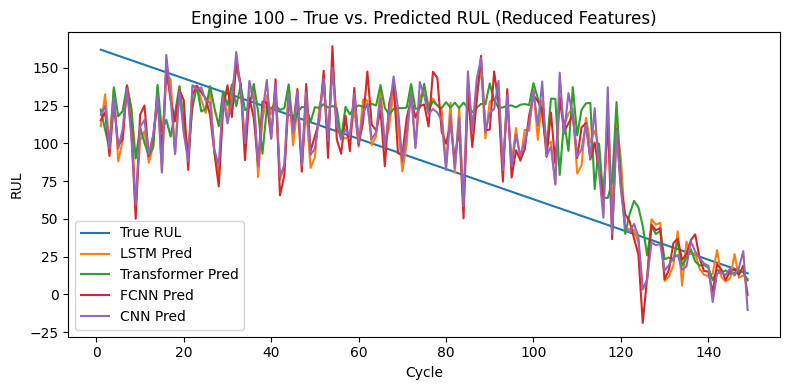

In [ ]:
engine_id_corr = list(test_seqs_corr.keys())[99]  # change as desired
seq_corr       = test_seqs_corr[engine_id_corr]


true_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq_corr['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq_corr['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq_corr['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq_corr['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq_corr['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq_corr['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq_corr['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq_corr['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id_corr} – True vs. Predicted RUL (Reduced Features)')
plt.legend()
plt.tight_layout()
plt.show()

## 12. PCA whitening

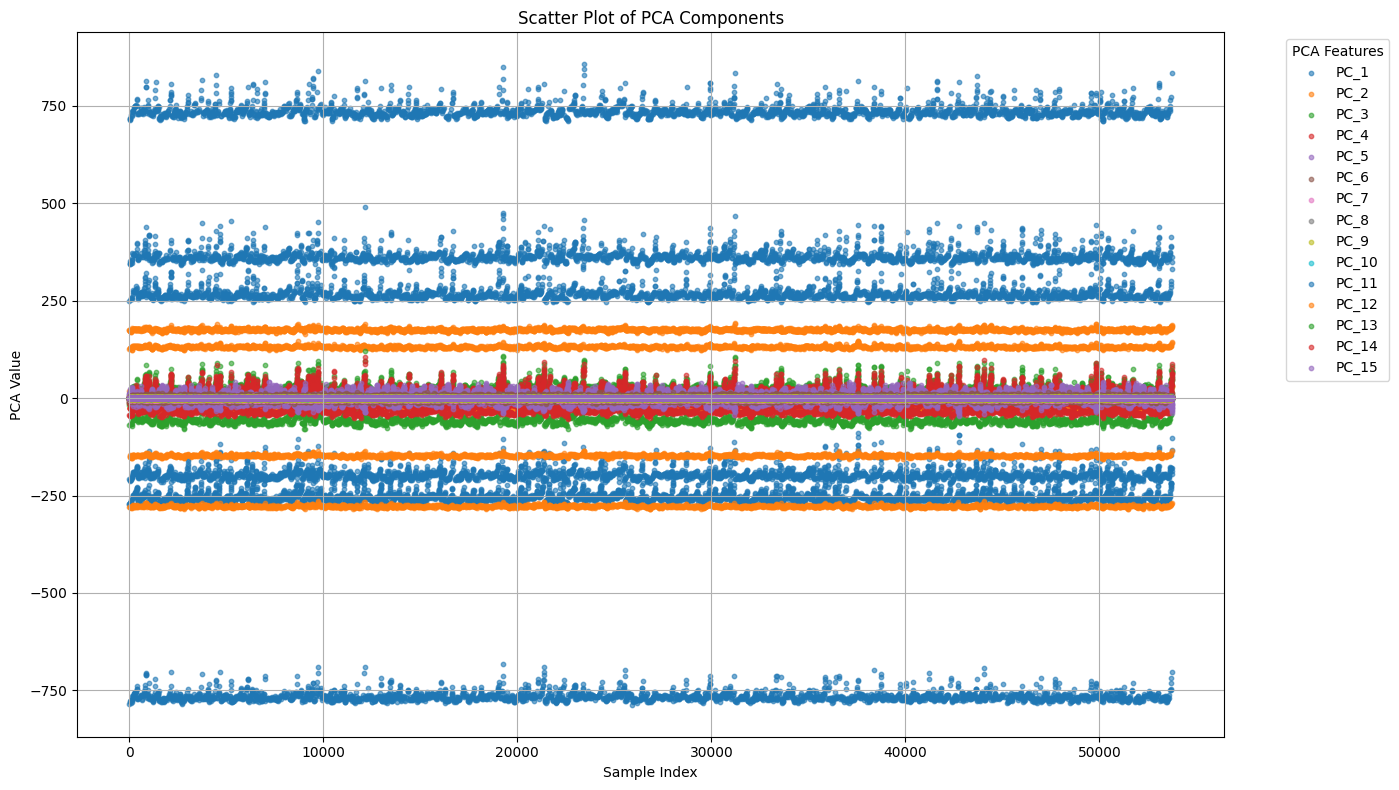

In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% variance
pca = PCA(n_components=15)
pca_features = pca.fit_transform(df[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features.shape[1])]
df_pca = pd.DataFrame(pca_features, columns=feature_cols_pca, index=df.index)

# Optional: downsample if too large
df_pca_plot_sample = df_pca.sample(n=20000, random_state=42) if len(df_pca) > 20000 else df_pca

# Create a scatter plot of all PCA components
plt.figure(figsize=(14, 8))

# Plot each PCA component in a different color
for i, col in enumerate(df_pca.columns):
    plt.scatter(df_pca_plot_sample.index, df_pca_plot_sample[col],
                label=col, s=10, alpha=0.6)

plt.title("Scatter Plot of PCA Components")
plt.xlabel("Sample Index")
plt.ylabel("PCA Value")
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), title="PCA Features")
plt.grid(True)
plt.tight_layout()
plt.show()

## 12.1. Create a copy of df for PCA transformation

In [ ]:
df_pca_applied = df.copy()

# Drop original feature columns from the copy
df_pca_applied.drop(columns=FEATURE_COLS, inplace=True)

# Add PCA-transformed features to the copy
df_pca_applied = pd.concat([df_pca_applied, df_pca], axis=1)

from sklearn.preprocessing import StandardScaler

# Fit a scaler on all training RUL values
rul_scaler_pca = StandardScaler()
train_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), TARGET_COL].values.reshape(-1, 1)
rul_scaler_pca.fit(train_ruls_pca)

# New column 'RUL_s' for the scaled targets
df_pca_applied['RUL_s'] = df_pca_applied[TARGET_COL].astype(np.float64).values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(train_ids), 'RUL_s'] = rul_scaler.transform(train_ruls_pca)

# Scale val targets (so loss is computed on same scale)
val_ruls_pca = df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), TARGET_COL].values.reshape(-1, 1)
df_pca_applied.loc[df_pca_applied[ID_COL].isin(val_ids), 'RUL_s'] = rul_scaler.transform(val_ruls_pca)

print(df_pca_applied.head)



<bound method NDFrame.head of        Engine_ID  Cy_F  Unnamed: 26  RUL        PC_1        PC_2        PC_3  \
0              1     1          NaN  148 -208.204948  125.866496  -17.814009   
1              1     2          NaN  147 -272.982427  173.856002   -1.163391   
2              1     3          NaN  146 -778.486310 -279.236754  -10.802359   
3              1     4          NaN  145 -273.205038  172.633908   -4.122136   
4              1     5          NaN  144 -784.702811 -279.158459  -13.219041   
...          ...   ...          ...  ...         ...         ...         ...   
53754        260   312          NaN    4  377.337168   33.672450   24.466192   
53755        260   313          NaN    3  480.006849   -8.972715  111.141210   
53756        260   314          NaN    2 -674.819074 -262.889018   70.365376   
53757        260   315          NaN    1 -674.342948 -263.364518   73.989298   
53758        260   316          NaN    0  -84.020103  148.192847   87.008280   

         

## 12.2. PCA-based sequence preparation

In [ ]:
def make_sequences_pca(df, ids, window_size):
    sequences = []
    for engine in ids:
        sub = df[df[ID_COL] == engine].sort_values(CYCLE_COL)
        data = sub[feature_cols_pca].values
        target = sub[TARGET_COL_S].values
        # sliding windows
        for i in range(len(sub) - window_size + 1):
            sequences.append((data[i:i+window_size], target[i+window_size-1]))
    return sequences

## 12.3. Data loader construction for PCA-based time-series sequences

In [ ]:
WINDOW_SIZE = 1

train_seqs_pca = make_sequences_pca(df_pca_applied, train_ids, WINDOW_SIZE)
val_seqs_pca   = make_sequences_pca(df_pca_applied, val_ids, WINDOW_SIZE)

train_ds_pca = SequenceDataset(train_seqs_pca)
val_ds_pca   = SequenceDataset(val_seqs_pca)

train_loader_pca = DataLoader(train_ds_pca, batch_size=64, shuffle=False)
val_loader_pca   = DataLoader(val_ds_pca, batch_size=64)

## 12.4. Data loader initialization for flattened PCA-based sequences

In [ ]:
flat_train_ds_pca = FlattenedDataset(train_seqs_pca)
flat_val_ds_pca   = FlattenedDataset(val_seqs_pca)

flat_train_loader_pca = DataLoader(flat_train_ds_pca, batch_size=64)
flat_val_loader_pca   = DataLoader(flat_val_ds_pca, batch_size=64)

## 13.1. Running LSTM for PCA-whitened data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pca   = LSTMRegressor(input_dim=len(feature_cols_pca), hidden_dim=128).to(device)
opt_lstm = torch.optim.Adam(lstm_pca.parameters(), lr=1e-3)
crit     = nn.MSELoss()

for epoch in range(1, 101):
    train_loss = train_epoch(lstm_pca, train_loader_pca, opt_lstm, crit, device)
    val_loss   = eval_model(lstm_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: LSTM Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: LSTM Train MSE=0.6984, Val MSE=0.8943
Epoch 2: LSTM Train MSE=0.5438, Val MSE=0.7821
Epoch 3: LSTM Train MSE=0.5127, Val MSE=0.7706
Epoch 4: LSTM Train MSE=0.4947, Val MSE=0.7473
Epoch 5: LSTM Train MSE=0.4846, Val MSE=0.7320
Epoch 6: LSTM Train MSE=0.4798, Val MSE=0.7253
Epoch 7: LSTM Train MSE=0.4749, Val MSE=0.7238
Epoch 8: LSTM Train MSE=0.4702, Val MSE=0.7229
Epoch 9: LSTM Train MSE=0.4667, Val MSE=0.7251
Epoch 10: LSTM Train MSE=0.4678, Val MSE=0.7625
Epoch 11: LSTM Train MSE=0.4653, Val MSE=0.7277
Epoch 12: LSTM Train MSE=0.4589, Val MSE=0.7264
Epoch 13: LSTM Train MSE=0.4581, Val MSE=0.7148
Epoch 14: LSTM Train MSE=0.4530, Val MSE=0.7181
Epoch 15: LSTM Train MSE=0.4507, Val MSE=0.7129
Epoch 16: LSTM Train MSE=0.4497, Val MSE=0.7073
Epoch 17: LSTM Train MSE=0.4480, Val MSE=0.7126
Epoch 18: LSTM Train MSE=0.4478, Val MSE=0.7129
Epoch 19: LSTM Train MSE=0.4444, Val MSE=0.7141
Epoch 20: LSTM Train MSE=0.4442, Val MSE=0.6955
Epoch 21: LSTM Train MSE=0.4426, Val MSE=0.6914
E

## 13.2. Running Transformer for PCA-whitened data

In [ ]:
trans_pca   = TransformerRegressor(input_dim=len(feature_cols_pca), d_model=64, nhead=4, num_layers=2).to(device)
opt_trans = torch.optim.Adam(trans_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(trans_pca, train_loader_pca, opt_trans, crit, device)
    val_loss   = eval_model(trans_pca, val_loader_pca, crit, device)
    print(f'Epoch {epoch}: Trans Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: Trans Train MSE=1.0478, Val MSE=1.3365
Epoch 2: Trans Train MSE=0.7389, Val MSE=0.9452
Epoch 3: Trans Train MSE=0.6575, Val MSE=0.8898
Epoch 4: Trans Train MSE=0.5893, Val MSE=0.7571
Epoch 5: Trans Train MSE=0.5162, Val MSE=0.7036
Epoch 6: Trans Train MSE=0.5009, Val MSE=0.6900
Epoch 7: Trans Train MSE=0.4942, Val MSE=0.6845
Epoch 8: Trans Train MSE=0.4851, Val MSE=0.6738
Epoch 9: Trans Train MSE=0.4777, Val MSE=0.6655
Epoch 10: Trans Train MSE=0.4753, Val MSE=0.6596
Epoch 11: Trans Train MSE=0.4733, Val MSE=0.6611
Epoch 12: Trans Train MSE=0.4678, Val MSE=0.6506
Epoch 13: Trans Train MSE=0.4667, Val MSE=0.6467
Epoch 14: Trans Train MSE=0.4633, Val MSE=0.6421
Epoch 15: Trans Train MSE=0.4611, Val MSE=0.6461
Epoch 16: Trans Train MSE=0.4598, Val MSE=0.6399
Epoch 17: Trans Train MSE=0.4583, Val MSE=0.6407
Epoch 18: Trans Train MSE=0.4559, Val MSE=0.6378
Epoch 19: Trans Train MSE=0.4553, Val MSE=0.6404
Epoch 20: Trans Train MSE=0.4520, Val MSE=0.6362
Epoch 21: Trans Train MSE=0.4

## 13.3. Running FCNN for PCA-whitened data

In [ ]:
fcnn_pca = FCRegressor(input_dim=len(feature_cols_pca) * WINDOW_SIZE).to(device)
opt_fcnn = torch.optim.Adam(fcnn_pca.parameters(), lr=1e-3)

for epoch in range(1, 101):
    train_loss = train_epoch(fcnn_pca, flat_train_loader_pca, opt_fcnn, crit, device)
    val_loss   = eval_model(fcnn_pca, flat_val_loader_pca, crit, device)
    print(f'Epoch {epoch}: FCNN Train MSE={train_loss:.4f}, Val MSE={val_loss:.4f}')

Epoch 1: FCNN Train MSE=2.0106, Val MSE=2.2508
Epoch 2: FCNN Train MSE=1.0118, Val MSE=0.8695
Epoch 3: FCNN Train MSE=0.7063, Val MSE=0.7363
Epoch 4: FCNN Train MSE=0.6041, Val MSE=0.7530
Epoch 5: FCNN Train MSE=0.5708, Val MSE=0.7952
Epoch 6: FCNN Train MSE=0.5316, Val MSE=0.8617
Epoch 7: FCNN Train MSE=0.5172, Val MSE=0.8177
Epoch 8: FCNN Train MSE=0.5049, Val MSE=0.8162
Epoch 9: FCNN Train MSE=0.5021, Val MSE=0.8135
Epoch 10: FCNN Train MSE=0.4927, Val MSE=0.8117
Epoch 11: FCNN Train MSE=0.4858, Val MSE=0.8167
Epoch 12: FCNN Train MSE=0.4805, Val MSE=0.7956
Epoch 13: FCNN Train MSE=0.4756, Val MSE=0.7873
Epoch 14: FCNN Train MSE=0.4704, Val MSE=0.8039
Epoch 15: FCNN Train MSE=0.4641, Val MSE=0.7862
Epoch 16: FCNN Train MSE=0.4587, Val MSE=0.7668
Epoch 17: FCNN Train MSE=0.4537, Val MSE=0.7613
Epoch 18: FCNN Train MSE=0.4517, Val MSE=0.7508
Epoch 19: FCNN Train MSE=0.4448, Val MSE=0.7502
Epoch 20: FCNN Train MSE=0.4445, Val MSE=0.7391
Epoch 21: FCNN Train MSE=0.4386, Val MSE=0.7261
E

## 13.4. Running CNN for PCA-whitened data

In [ ]:
cnn_model_pca = CNNRegressor(num_features=len(feature_cols_pca), window_size=WINDOW_SIZE).to(device)

# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model_pca.parameters(), lr=1e-3, weight_decay=1e-5)


for epoch in range(1, 101):
    cnn_model_pca.train()
    total_loss = 0
    for xb, yb in train_loader_pca:
        xb, yb = xb.to(device), yb.to(device)
        preds = cnn_model_pca(xb)
        loss = loss_fn(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_train_loss = total_loss / len(train_loader_pca.dataset)

    # Validation
    cnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader_pca:
            xb, yb = xb.to(device), yb.to(device)
            preds = cnn_model_pca(xb)
            loss = loss_fn(preds, yb)
            val_loss += loss.item() * xb.size(0)
    avg_val_loss = val_loss / len(val_loader_pca.dataset)

    print(f'Epoch {epoch}: CNN Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}')

Epoch 1: CNN Train Loss=0.8438, Val Loss=0.7846
Epoch 2: CNN Train Loss=0.5849, Val Loss=0.8052
Epoch 3: CNN Train Loss=0.5316, Val Loss=0.8420
Epoch 4: CNN Train Loss=0.4975, Val Loss=0.7979
Epoch 5: CNN Train Loss=0.4807, Val Loss=0.7795
Epoch 6: CNN Train Loss=0.4695, Val Loss=0.7482
Epoch 7: CNN Train Loss=0.4624, Val Loss=0.7371
Epoch 8: CNN Train Loss=0.4553, Val Loss=0.7408
Epoch 9: CNN Train Loss=0.4509, Val Loss=0.7296
Epoch 10: CNN Train Loss=0.4472, Val Loss=0.7267
Epoch 11: CNN Train Loss=0.4424, Val Loss=0.7092
Epoch 12: CNN Train Loss=0.4401, Val Loss=0.7048
Epoch 13: CNN Train Loss=0.4386, Val Loss=0.7018
Epoch 14: CNN Train Loss=0.4366, Val Loss=0.6969
Epoch 15: CNN Train Loss=0.4340, Val Loss=0.6879
Epoch 16: CNN Train Loss=0.4315, Val Loss=0.6957
Epoch 17: CNN Train Loss=0.4310, Val Loss=0.6832
Epoch 18: CNN Train Loss=0.4283, Val Loss=0.6842
Epoch 19: CNN Train Loss=0.4280, Val Loss=0.6765
Epoch 20: CNN Train Loss=0.4277, Val Loss=0.6890
Epoch 21: CNN Train Loss=0.42

## 14. Comparing final validation losses for PCA-whitened data

In [ ]:
lstm_val  = eval_model(lstm_pca, train_loader_pca, crit, device)
trans_val = eval_model(trans_pca, train_loader_pca, crit, device)
fcnn_val  = eval_model(fcnn_pca, flat_train_loader_pca, crit, device)
cnn_val   = eval_model(cnn_model_pca, train_loader_pca, loss_fn, device)
print(f'Final Val MSE - LSTM: {lstm_val:.4f}, Transformer: {trans_val:.4f}, FCNN: {fcnn_val:.4f}, CNN: {cnn_val:.4f}')

Final Val MSE - LSTM: 0.3913, Transformer: 0.3980, FCNN: 0.3895, CNN: 0.4024


## 15. Load test data and run interface for PCA-whitened data

In [ ]:
import matplotlib.pyplot as plt

test_df_pca   = test_df.copy()

# Apply same scaling
# test_df[FEATURE_COLS] = scaler.transform(test_df[FEATURE_COLS])
test_df_pca[FEATURE_COLS] = scaler_raw.transform(test_df_pca.loc[:, FEATURE_COLS])
test_df_pca[TARGET_COL_S] = rul_scaler_pca.transform(test_df_pca[[TARGET_COL]])

# Apply PCA to retain 95% variance
pca_features_test = pca.transform(test_df_pca[FEATURE_COLS])

# Create new PCA column names and replace original features
feature_cols_pca = [f'PC_{i+1}' for i in range(pca_features_test.shape[1])]
df_pca_test = pd.DataFrame(pca_features_test, columns=feature_cols_pca, index=test_df_pca.index)
# Create a copy of df for PCA transformation
df_pca_applied_test = test_df_pca.copy()
# Drop original feature columns from the copy
df_pca_applied_test.drop(columns=FEATURE_COLS, inplace=True)
# Add PCA-transformed features to the copy
df_pca_applied_test = pd.concat([df_pca_applied_test, df_pca], axis=1)


def make_test_sequences_pca(df, window_size):
    df = df.sort_values([ID_COL, 'Cy'])
    results = {}
    for eng in df[ID_COL].unique():
        sub     = df[df[ID_COL]==eng]
        X       = sub[feature_cols_pca].values
        y_true  = sub[TARGET_COL_S].values
        cycles  = sub['Cy'].values
        preds_l = []
        preds_t = []
        preds_f = []
        preds_c = []
        cyc_lst = []
        true_lst= []
        for i in range(window_size, len(sub)+1):
            x_win = torch.tensor(X[i-window_size:i], dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                preds_l.append(lstm_pca(x_win).item())
                preds_t.append(trans_pca(x_win).item())
                preds_f.append(fcnn_pca(x_win).item())
                preds_c.append(cnn_model_pca(x_win).item())
            cyc_lst.append(cycles[i-1])
            true_lst.append(y_true[i-1])
        results[eng] = {
            'cycle': cyc_lst,
            'true' : true_lst,
            'lstm' : preds_l,
            'trans': preds_t,
            'fcnn' : preds_f,
            'cnn'  : preds_c
        }
    return results

test_seqs = make_test_sequences_pca(df_pca_applied_test, WINDOW_SIZE)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 16. Plot and save for a chosen engine for PCA-whitened data

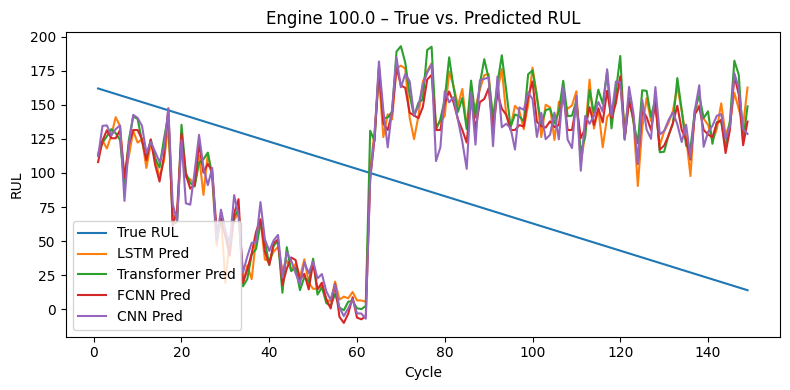

In [ ]:
engine_id = list(test_seqs.keys())[99]  # change as desired
seq       = test_seqs[engine_id]


true_unscaled = rul_scaler.inverse_transform(np.array(seq['true']).reshape(-1,1)).flatten()
lstm_unscaled = rul_scaler.inverse_transform(np.array(seq['lstm']).reshape(-1,1)).flatten()
trans_unscaled= rul_scaler.inverse_transform(np.array(seq['trans']).reshape(-1,1)).flatten()
fcnn_unscaled = rul_scaler.inverse_transform(np.array(seq['fcnn']).reshape(-1,1)).flatten()
cnn_unscaled  = rul_scaler.inverse_transform(np.array(seq['cnn']).reshape(-1,1)).flatten()

plt.figure(figsize=(8,4))

plt.plot(seq['cycle'], true_unscaled,  label='True RUL')
plt.plot(seq['cycle'], lstm_unscaled,  label='LSTM Pred')
plt.plot(seq['cycle'], trans_unscaled, label='Transformer Pred')
plt.plot(seq['cycle'], fcnn_unscaled,   label='FCNN Pred')
plt.plot(seq['cycle'], cnn_unscaled,    label='CNN Pred')

plt.xlabel('Cycle')
plt.ylabel('RUL')
plt.title(f'Engine {engine_id} – True vs. Predicted RUL')
plt.legend()
plt.tight_layout()
plt.show()